In [25]:
### Importing libraries

%matplotlib inline
import numpy as np
import time

import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8, 8), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 16}
from matplotlib import cm
plt.rcParams.update(newparams)

from sympy import symbols, nonlinsolve, S, solveset
a=1

In [26]:
def plot_solution(x, y, U, txt='Solution'):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    X, Y = np.meshgrid(x,y)
    
    ax.plot_surface(X, Y, U, cmap=cm.coolwarm)
    ax.view_init(azim=300)              # Rotate the figure
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(txt)


In [27]:
# Simple function to test with, x^2 + y^2
# #All this functions are on index, meaning there is happening a 2 till one scaling between x an y
def f1_anal(x, y):
    return x**2+y**2
    
def f1(x,y,r):
    return -((a+1)*(2) +2* r**2)

def gE1(y):
    return 1**2 + y**2

def gW1(y):
    return 0 + y**2

def gN1(x):
    return x**2 + 2**2

def gS1(x):
    return x**2 + 0

In [28]:
#All this functions are on index, meaning there is happening a 2 till one scaling between x an y

def f2_anal(x,y):
        return np.cos(x)*np.sin(y)

def f2(x,y,r):
    return -(-np.cos(x)*np.sin(y)*(a + 1) - 2*r*np.cos(y)*np.sin(x)  - r**2*np.cos(x)*np.sin(y))

def gE2(y):
    return np.cos(1)*np.sin(y)

def gW2(y):
    return np.cos(0)*np.sin(y)

def gN2(x):
    return np.cos(x)*np.sin(2)

def gS2(x):
    return np.cos(x)*np.sin(0)

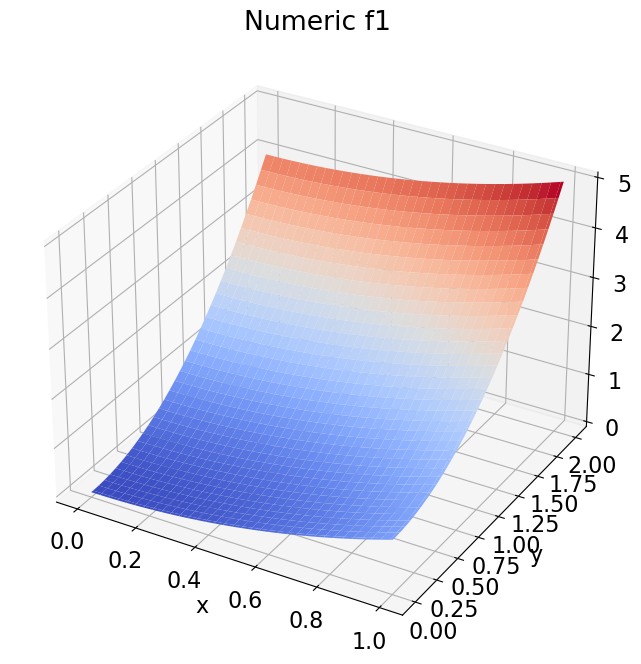

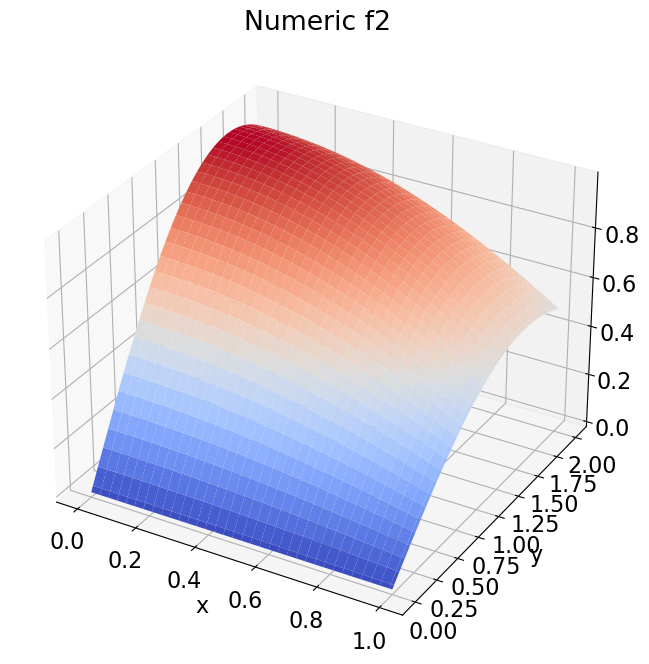

In [29]:

def scheme1(a,M,r,f,gE,gW,gN,gS, plot=False):
    h = 1/M
    k = r*h
    N = int(np.ceil(2/k)) 

    #Define B
    vec = np.ones((M-1)*(N-1))
    vec[M-2::M-1] =0
    B = np.diag(np.ones((M-1)*(N-1))*(2*a+2))
    B+= np.diag(vec[:-1]*-a,1)
    B+= np.diag(vec[:-1]*-a,-1)
    B+= np.diag(vec[:-M]*-1,M)
    B+= np.diag(vec[:-M]*-1,-M)

    #Define F
    F = np.zeros((M-1)*(N-1))
    for i in range((M-1)*(N-1)):
        F[i] = h*h* f(h*((i)%(M-1)+1),k*(int(i/(M-1))+1), r)

    #Define G
    G = np.zeros((M-1)*(N-1))
    
    for i in range(1,M-1):
        G[i] += gS((i)*h)                                   #South/Down

    for i in range(M-2):
        G[(M-1)*(N-2)+i] += gN((i+2)*h)                     #North/Up

    for i in range(N-1):
        G[(M-2)+(M-1)*i] += a*gE((i+1)*k)  + gE((i+2)*k)    #East/Right

    for i in range(N-1):
        G[(M-1)*i] += a*gW((i+1)*k) +gW(i*k)                #West/Left
       

    #Solve equation 
    U = np.flip(np.reshape(np.linalg.solve(B,F+G),(N-1,M-1)), 0) 

    #Padding with boundary conditions
    U = np.pad(U,(1,1))
    U[:,-1] =np.flip(gE(np.arange(0,N+1)*k))
    U[:,0]  =np.flip(gW(np.arange(0,N+1)*k))
    U[-1,:] =gS(np.arange(0,M+1)*h)
    U[0,:] =gN(np.arange(0,M+1)*h)
    

    #Plotting
    if plot==True:
        plot_solution(np.linspace(0,1,M+1, endpoint=True),np.linspace(N*k,0,N+1, endpoint=True),U,txt="Numeric " + f.__name__)
        
    return U

U_test1 = scheme1(a=1,r=2,M=100,f=f1,gE=gE1,gW=gW1,gN=gN1,gS=gS1, plot=True)
U_test2 = scheme1(a=1,r=2,M=100,f=f2,gE=gE2,gW=gW2,gN=gN2,gS=gS2, plot=True)

In [30]:
def U_anal_M(M, N,f_anal=f1_anal, plot=False):
    x = np.linspace(0,1,M+1)
    y = np.linspace(2,0,N+1)
    XX, YY = np.meshgrid(x,y)
    U_analytic = f_anal(XX,YY)

    if plot:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(XX, YY, U_analytic, cmap=cm.coolwarm)
        ax.view_init(azim=300)                                    # Rotate the figure
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(r"Analytic " + f1_anal.__name__)
        plt.show()
        
    return U_analytic, XX, YY

In [31]:
def convergence(r, f, gE,gW,gN,gS, f_anal, P=5, error_plot=False): 

    H_arr = np.zeros(P)
    Error_arr = np.zeros(P)
    M = 10
    h=1/M

    for i in range(0,P):

        U = scheme1(a=1,M=M,r=r,f=f,gE=gE,gW=gW,gN=gN,gS=gS, plot=False)
        h = 1/M
        k = r*h 
        N = int(np.ceil(2/k))
        U_an, XX, YY = U_anal_M(M, N, f_anal=f_anal, plot=False)
        
        Error_arr[i] = np.max(np.abs(U - U_an))

        if error_plot:
            fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
            ax.plot_surface(XX, YY, np.abs(U-U_an), cmap=cm.coolwarm)
            ax.view_init(azim=100)              # Rotate the figure
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(r"Error plot " + f.__name__)
            
        
            plt.show()
        
        H_arr[i]=1/M
        M = 2*M
        
    order = np.polyfit(np.log(H_arr),np.log((Error_arr)),1)[0]
    return H_arr, Error_arr, order

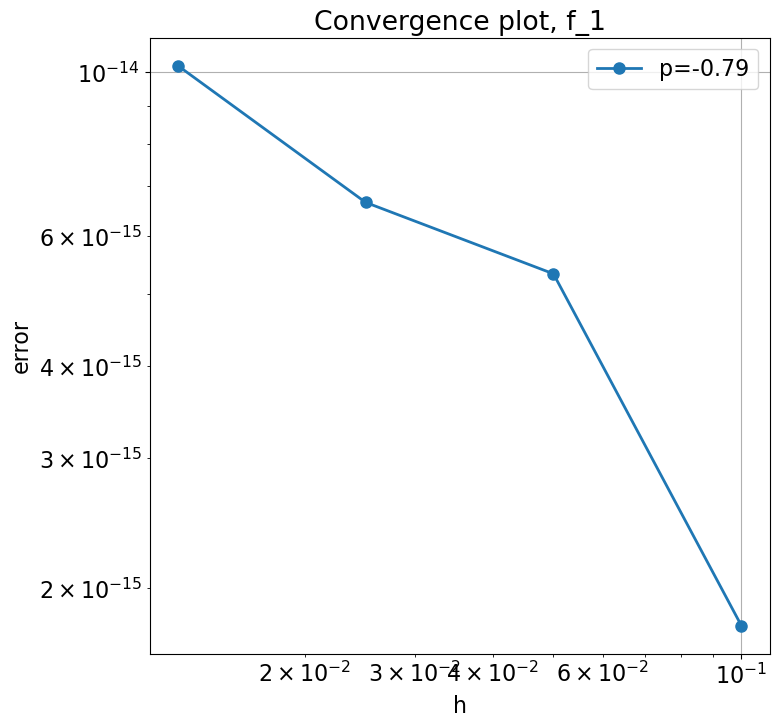

In [32]:
H0, E0, p0 = convergence(r=2, f=f1, gE=gE1,gW=gW1,gN=gN1,gS=gS1,f_anal=f1_anal, P=4)
plt.loglog(H0,E0,'o-', label='p={:.2f}'.format(p0))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()
plt.title("Convergence plot, f_1")
plt.show()

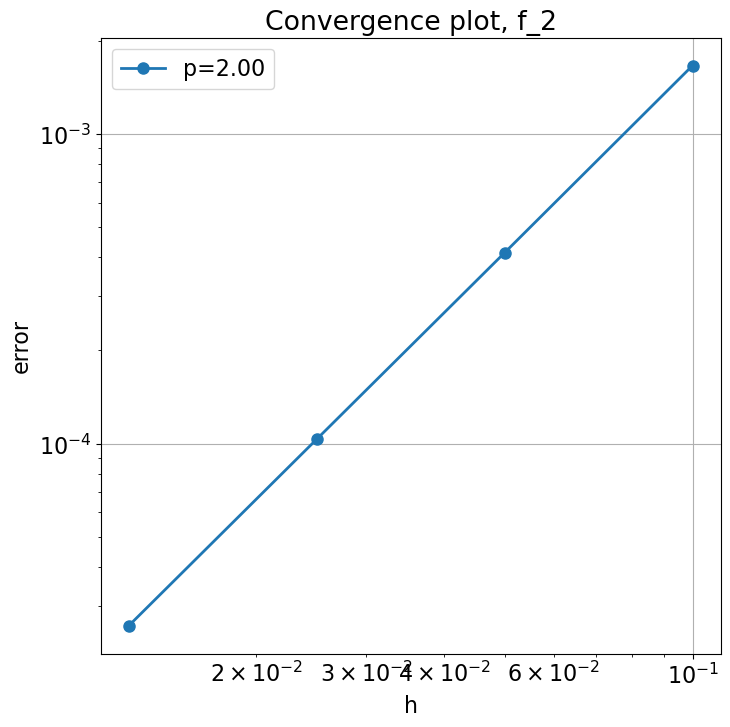

In [33]:
H00, E00, p00 = convergence(r=2, f=f2, gE=gE2,gW=gW2,gN=gN2,gS=gS2,f_anal=f2_anal, P=4)
plt.loglog(H00,E00,'o-', label='p={:.2f}'.format(p00))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()
plt.title("Convergence plot, f_2")
plt.show()

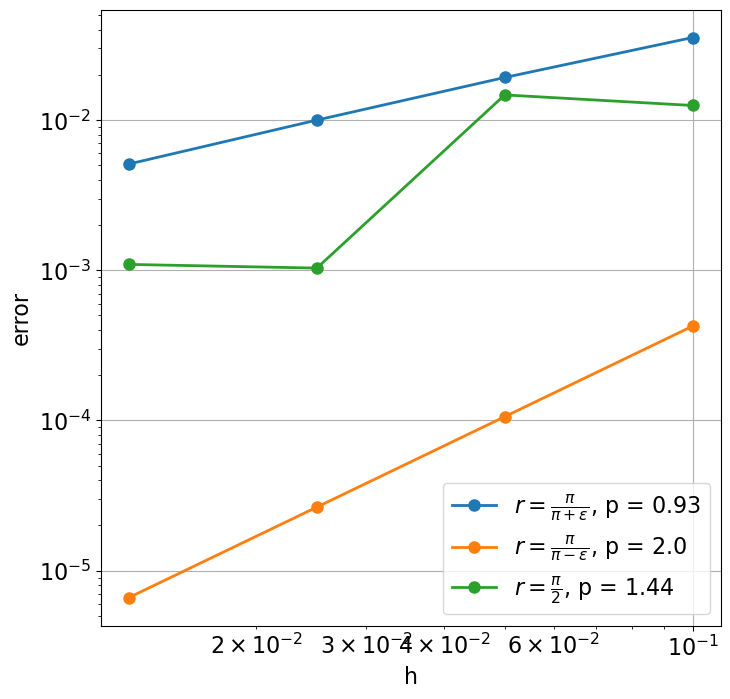

In [34]:
epsilon = 10E-10
H2, E2, p2 = convergence(r=np.pi/(np.pi+epsilon), f=f2, gE=gE2,gW=gW2,gN=gN2,gS=gS2,f_anal=f2_anal, P=4,error_plot=False)
H3, E3, p3 = convergence(r=np.pi/(np.pi-epsilon), f=f2, gE=gE2,gW=gW2,gN=gN2,gS=gS2,f_anal=f2_anal, P=4,error_plot=False)

H6, E6, p6 = convergence(r=np.pi/2, f=f2, gE=gE2,gW=gW2,gN=gN2,gS=gS2,f_anal=f2_anal, P=4,error_plot=False)

plt.loglog(H2,E2,'o-', label=r'$r = \frac{\pi}{\pi + \epsilon}$, p = ' + str(round(p2,2)))
plt.loglog(H3,E3,'o-', label=r'$r = \frac{\pi}{\pi - \epsilon}$, p = ' + str(round(p3,2)))
plt.loglog(H6,E6,'o-', label=r'$r = \frac{\pi}{2}$, p = ' + str(round(p6,2)))


plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()
plt.show()

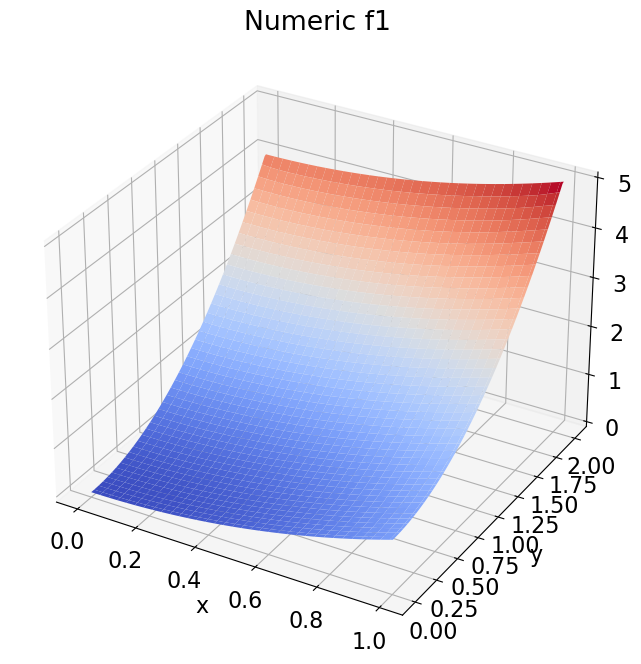

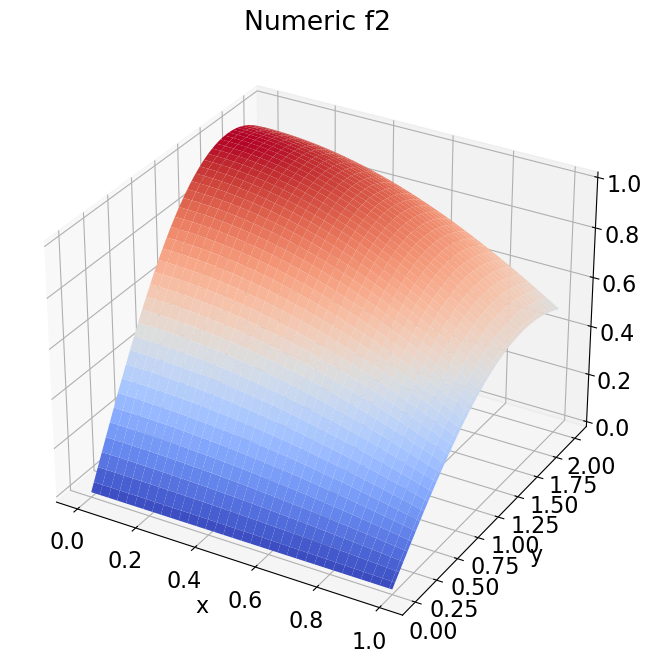

In [35]:
U_test1_r = scheme1(a=1,r=np.pi/2,M=100,f=f1,gE=gE1,gW=gW1,gN=gN1,gS=gS1, plot=True)
U_test2_r = scheme1(a=1,r=np.pi/2,M=100,f=f2,gE=gE2,gW=gW2,gN=gN2,gS=gS2, plot=True)

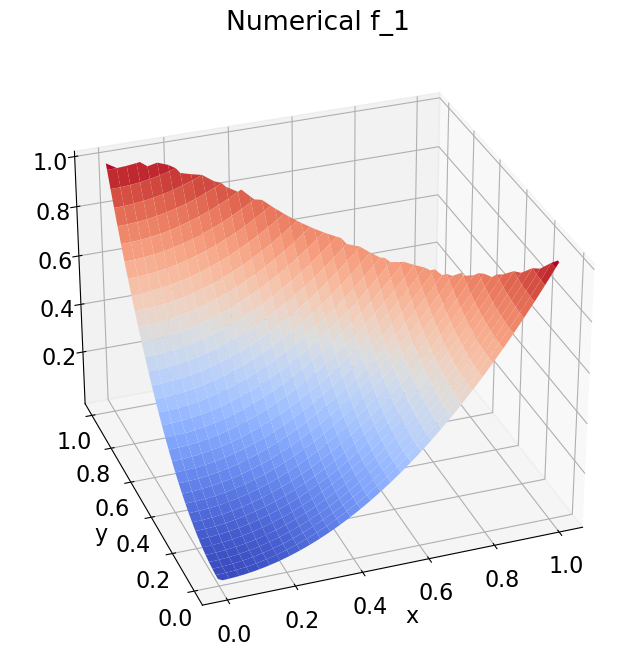

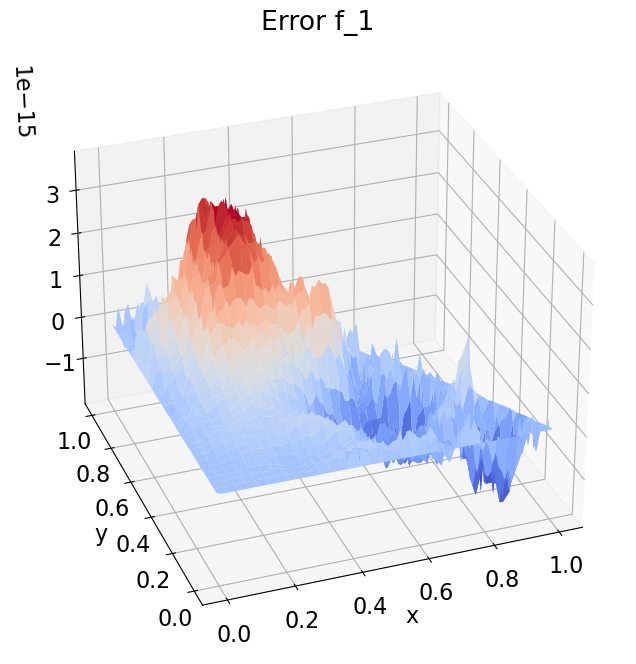

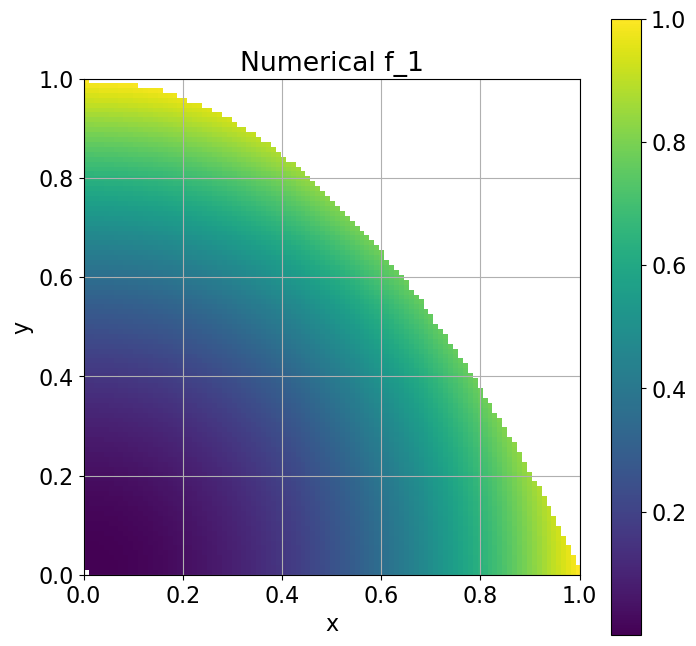

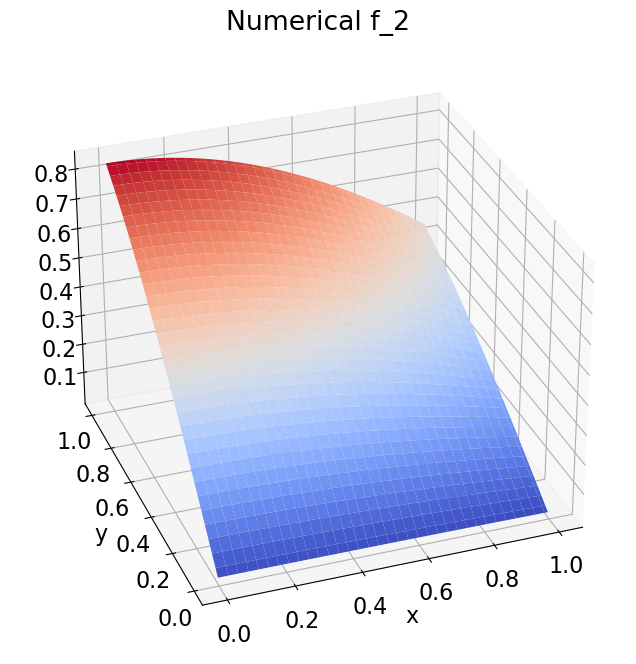

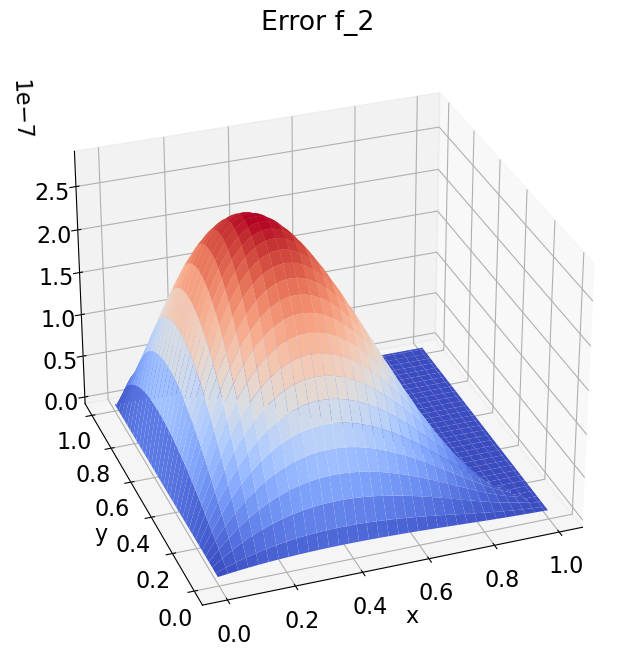

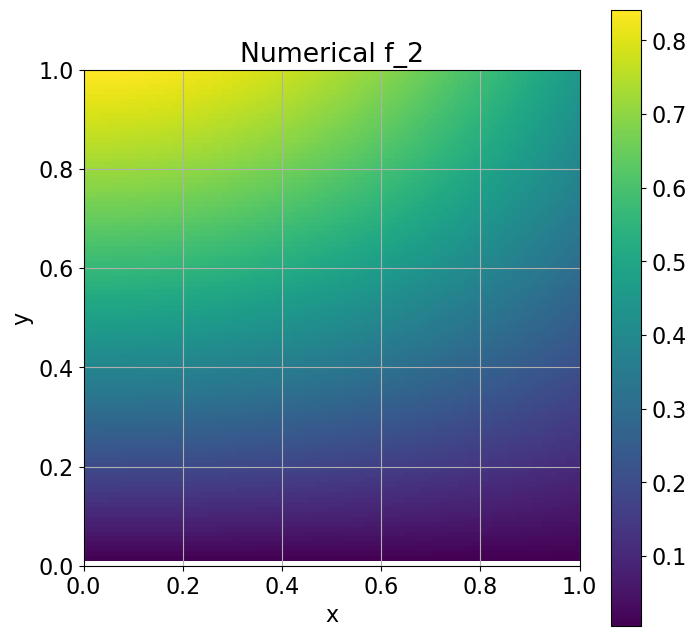

In [36]:
#TASK 2
#new format for test functions for different scheme
def f_1(x,y):
    return -4

def g_1(x,y):
    return x**2+y**2

def f_2(x, y):
    return -(-np.cos(x)*np.sin(y) -np.cos(x)*np.sin(y))

def g_2(x, y):
    return np.cos(x)*np.sin(y)


#ADDING BOUNDARY NODES TO THE GRID
def scheme2(M=10, f=f_1, g=g_1, plot=False, error=False, zero_outside=False):
    numfix = 0.0000001
    h = 1/M
    Num_points_row = np.floor(np.sqrt(-np.arange(1,M)*h+1)/h-numfix*h).astype(int) #number of grid points in each row
    #**************************** BE AWARE OF DIRTY FIX ABOVE *****************
    # To ensure that we use the last point on a row as a boundary if it actually is a boundary point, commented on in 3.3 Observations where numfix is zeta

    Num_points_row_cum = np.cumsum(Num_points_row).astype(int) #count of point not index

    A = np.zeros((Num_points_row_cum[-1],Num_points_row_cum[-1]))
    F = np.zeros(Num_points_row_cum[-1])
    G = np.zeros(Num_points_row_cum[-1])

    index = 0
    for i in range(len(Num_points_row)):
        for j in range(Num_points_row[i]):
            F[index] = h*h*f((j+1)*h,(i+1)*h) #Define F
            
            if(j==0 and j == Num_points_row[i]-1):
                eta_X = np.sqrt(1-(i+1)*h)/h-Num_points_row[i]
                G[index] += 2/(1+eta_X)*g(0,(i+1)*h) + (2/(eta_X*(1+eta_X)))*g((j+1+eta_X)*h,(i+1)*h)
                A[index][index] += (2/eta_X)
            elif j==0:
                G[index] += g(0,(i+1)*h) #Set West/Left Border
                A[index][index+1] += -1
                A[index][index] += 2
            elif j == Num_points_row[i]-1:
                eta_X = np.sqrt(1-(i+1)*h)/h-Num_points_row[i]
                G[index] += (2/(eta_X*(1+eta_X)))*g((j+1+eta_X)*h,(i+1)*h)
                A[index][index-1] += -2/(1+eta_X)
                A[index][index] += (2/eta_X)
            else:
                A[index][index-1] += -1
                A[index][index+1] += -1
                A[index][index] += 2
        
            if (i==0 and (i+1)*h <= 1-((j+1)*h)**2 <= (i+2+numfix)*h):
                eta_Y = (1-((j+1)*h)**2)/h-(i+1)
                A[index][index] += (2/eta_Y)
                G[index] += 2/(1+eta_Y)*g((j+1)*h,0) + (2/(eta_Y*(1+eta_Y)))*g((j+1)*h,(i+1+eta_Y)*h)
            elif i==0:
                G[index] += g((j+1)*h,0) #Set South/Down Border
                A[index][index+Num_points_row[i]] += -1
                A[index][index] += 2
            elif (i+1)*h <= 1-((j+1)*h)**2 <= (i+2+numfix)*h:
                eta_Y = (1-((j+1)*h)**2)/h-(i+1)
                G[index] += (2/(eta_Y*(1+eta_Y)))*g((j+1)*h,(i+1+eta_Y)*h)
                A[index][index-Num_points_row[i-1]] += -2/(1+eta_Y)
                A[index][index] += (2/eta_Y)
            else:
                A[index][index-Num_points_row[i-1]] += -1
                A[index][index+Num_points_row[i]] += -1
                A[index][index] += 2
            index +=1

        
    np.set_printoptions(precision=2,suppress=True)

    U = np.linalg.solve(A,F+G)
    X, Y = np.meshgrid(np.linspace(0,1,M+1),np.linspace(0,1,M+1))

    if zero_outside == True:
        U_matrix = np.zeros((M+1, M+1))
    else:
        U_matrix = g(X,Y)

    #from vector til matrix
    index = 0
    for i in range(len(Num_points_row)):
        for j in range(Num_points_row[i]):
            U_matrix[i+1][j+1] = U[index]
            index +=1
        if zero_outside == True: 
            U_matrix[i+1][Num_points_row[i]+1] = g((i+1)*h, (Num_points_row[i]+1)*h)

    if zero_outside == True:
        for i in range(M+1):
            U_matrix[0][i] = g((i)*h, 0)
            U_matrix[i][0] = g(0, i*h)
        #U_matrix[i+1][Num_points_row[i]] = g((Num_points_row[i]+1)*h, (i+1)*h)

    if plot:
        U_matrix[ U_matrix==0 ] = np.nan #matplotlib does not plot nans, but it plots zeroes. This makes it prettier
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(X, Y, U_matrix, cmap=cm.coolwarm)
        ax.view_init(azim=250)              # Rotate the figure
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(r"Numerical " + f.__name__)
        plt.show()
    
    if error and plot:
        X, Y = np.meshgrid(np.linspace(0,1,M+1),np.linspace(0,1,M+1))
        U_matrix_anal = g(X,Y)

        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(X, Y, U_matrix-U_matrix_anal, cmap=cm.coolwarm)
        ax.view_init(azim=250)              # Rotate the figure
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Error')
        plt.title(r"Error " + f.__name__)
        plt.show()

    return U_matrix

U_test = scheme2(M=100, f=f_1, g=g_1, plot=True, error=True, zero_outside=True)

plt.imshow(np.flip(U_test,axis=0), extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(r"Numerical " + f_1.__name__)
plt.show()

U_test2 = scheme2(M=100, f=f_2, g=g_2, plot=True, error=True,zero_outside=False)

plt.imshow(np.flip(U_test2,axis=0), extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(r"Numerical " + f_2.__name__)
plt.show()
           

In [37]:

def f_1_(x,y):
    return -4

#be aware that g needs to be evaluated on closest point on the boundary in the point 
def g_1_(x,y,findNearest=False):
    if findNearest:
        #r = -(3/2 - 3*y)/(3*(-27*x/4 + np.sqrt(729*x**2/4 - 4*(3/2 - 3*y)**3)/2)**(1/3)) - (-27*x/4 + np.sqrt(729*x**2/4 - 4*(3/2 - 3*y)**3)/2)**(1/3)/3
        r = symbols('r',real=True)

        eq = x + r - 2*r*y - 2*r**3 
        b = list((solveset(eq ,r,domain=S.Reals))).pop()
        x = b
        y = 1-b**2
    return x**2+y**2

def f_2_(x, y):
    return -(-np.cos(x)*np.sin(y) -np.cos(x)*np.sin(y))

def g_2_(x,y,findNearest=False):
    
    if findNearest:
        #r = -(3/2 - 3*y)/(3*(-27*x/4 + np.sqrt(729*x**2/4 - 4*(3/2 - 3*y)**3)/2)**(1/3)) - (-27*x/4 + np.sqrt(729*x**2/4 - 4*(3/2 - 3*y)**3)/2)**(1/3)/3
        r = symbols('r',real=True)

        eq = x + r  - 2*r*y - 2*r**3 
        b = list((solveset(eq ,r,domain=S.Reals))).pop()
        x1 = float(b)
        y1 = float(1-b**2)
        return np.cos(x1)*np.sin(y1)
    return np.cos(x)*np.sin(y)


def f_3(x, y):
    return -(4*(3*x**2 +y-5)+2)

def g_3(x, y, findNearest=False):
    if findNearest:
        #r = -(3/2 - 3*y)/(3*(-27*x/4 + np.sqrt(729*x**2/4 - 4*(3/2 - 3*y)**3)/2)**(1/3)) - (-27*x/4 + np.sqrt(729*x**2/4 - 4*(3/2 - 3*y)**3)/2)**(1/3)/3
        r = symbols('r',real=True)

        eq = x + r  - 2*r*y - 2*r**3 
        b = list((solveset(eq ,r,domain=S.Reals))).pop()
        x1 = float(b)
        y1 = float(1-b**2)
        return (1-x1**2-y1+4)**2

    return (1 - x**2 -y + 4)**2

In [38]:
def convergence2(f=f_1_, g=g_1_, P=5, M=4,error_plot=False, conv_plot=False, scheme=scheme2): 

    H_arr = np.zeros(P)
    Error_arr = np.zeros(P)
    h=1/M
    
    for i in range(0,P):

        U_num = scheme(M=M, f=f, g=g, plot=False, error=False)
        h = 1/M

        X, Y = np.meshgrid(np.linspace(0,1,M+1),np.linspace(0,1,M+1))
        U_an = g(X, Y)
    
        Error_arr[i] = np.max(np.abs(U_num - U_an))

        if error_plot:
            fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
            ax.plot_surface(X, Y, np.abs(U_num-U_an), cmap=cm.coolwarm)
            ax.view_init(azim=300)              # Rotate the figure
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title("error")
        
            plt.show()
        
        H_arr[i]=1/M
        M = M*2
        
    order = np.polyfit(np.log(H_arr),np.log((Error_arr)),1)[0]

    if conv_plot:
            print(f"The code gives us a order of {order}.")
            plt.loglog(H_arr,Error_arr,'o-', label='p={:.2f}'.format(order))
            plt.grid('on')
            plt.xlabel('h')
            plt.ylabel('error')
            plt.title(r"Convergence plot " + f.__name__)
            plt.legend()
            plt.show()
            
    return H_arr, Error_arr, order

The code gives us a order of -0.8124213647266546.


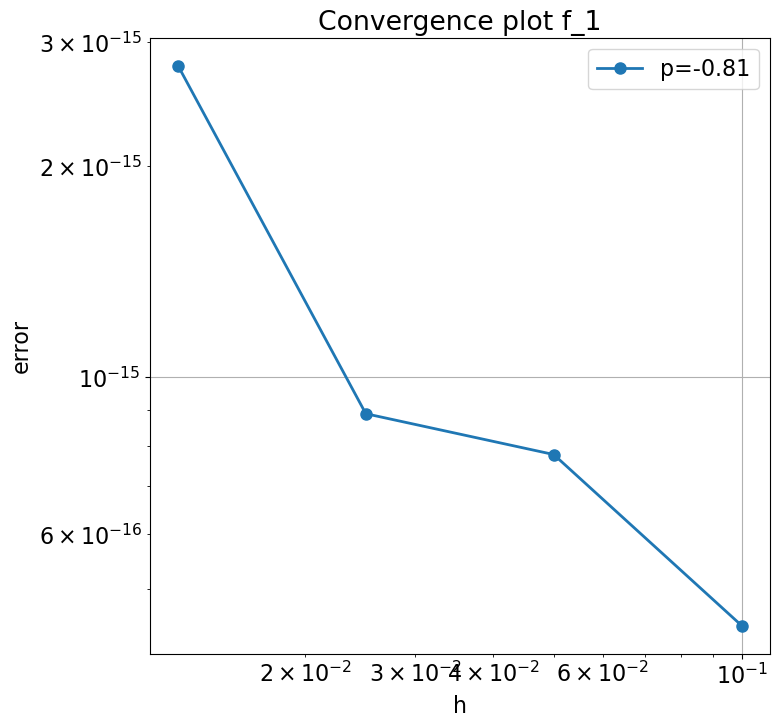

CPU times: total: 1.47 s
Wall time: 1.04 s


In [39]:
%%time
H1, E1, p1 = convergence2(f=f_1, g=g_1, P=4,M=10, conv_plot=True, scheme=scheme2)

The code gives us a order of 2.06194508585071.


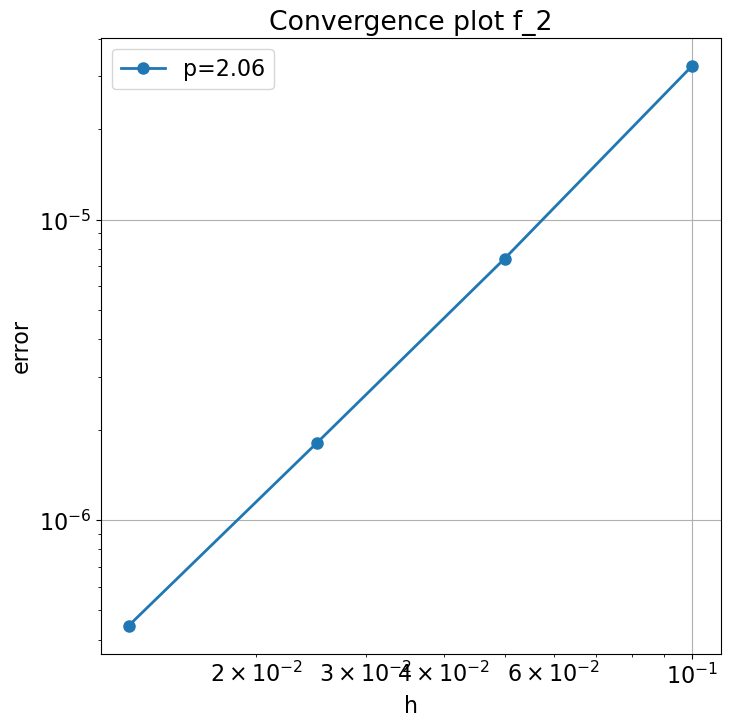

CPU times: total: 1.45 s
Wall time: 1.03 s


In [40]:
%%time
H2, E2, p2 = convergence2(f=f_2, g=g_2, P=4,M=10, conv_plot=True, scheme=scheme2)

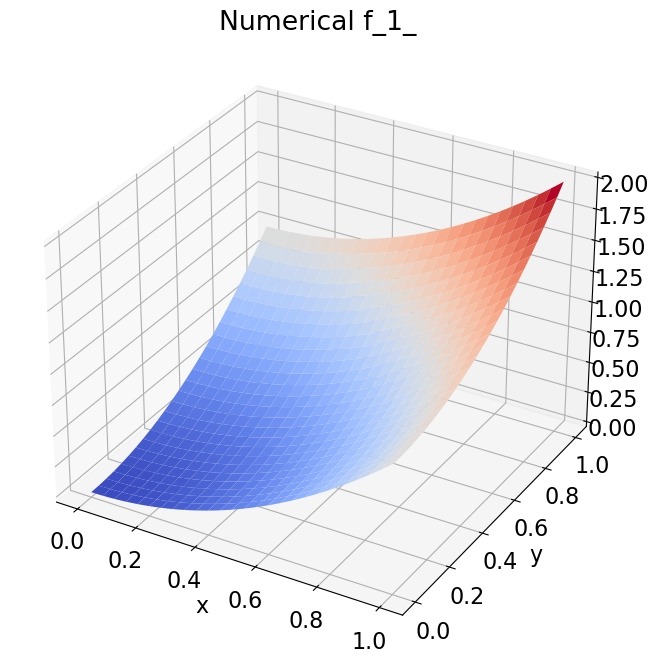

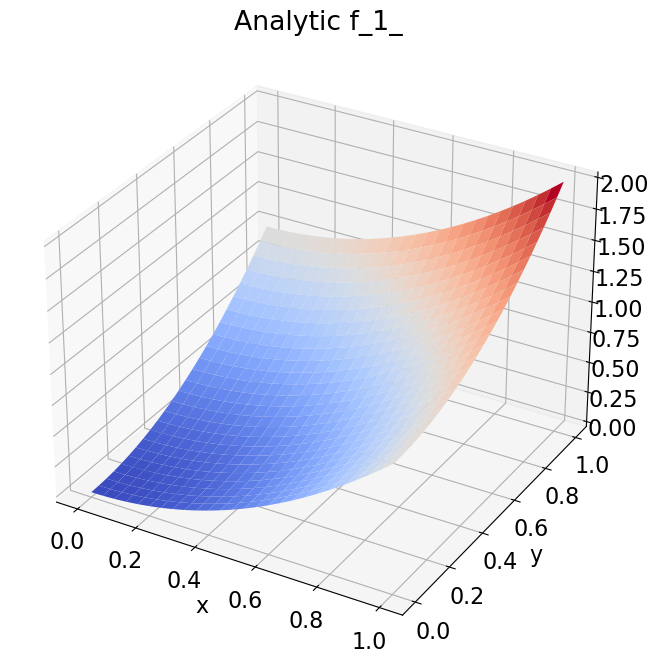

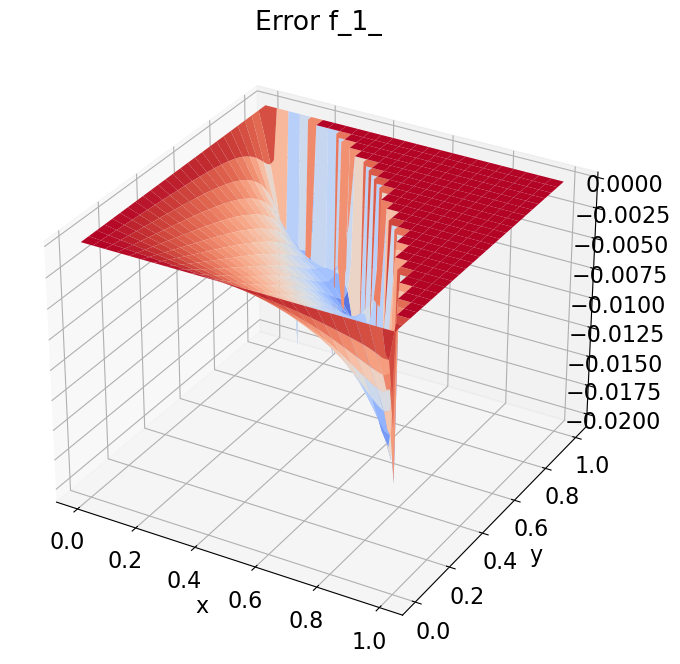

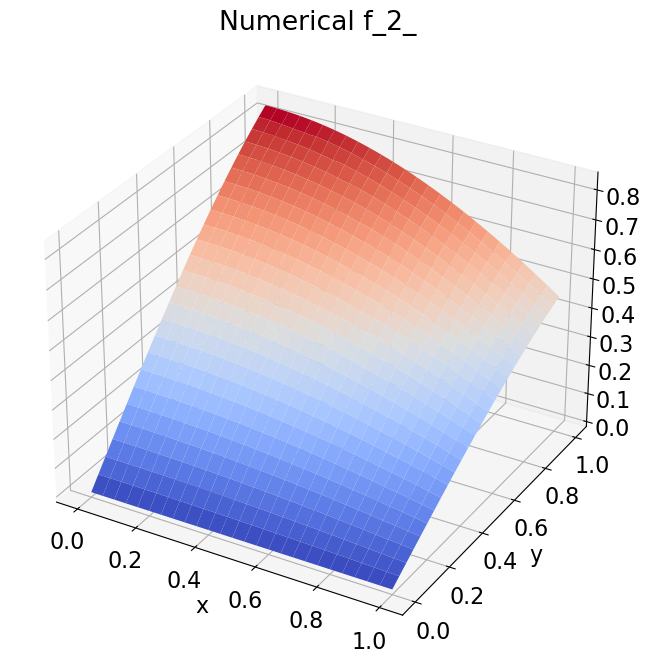

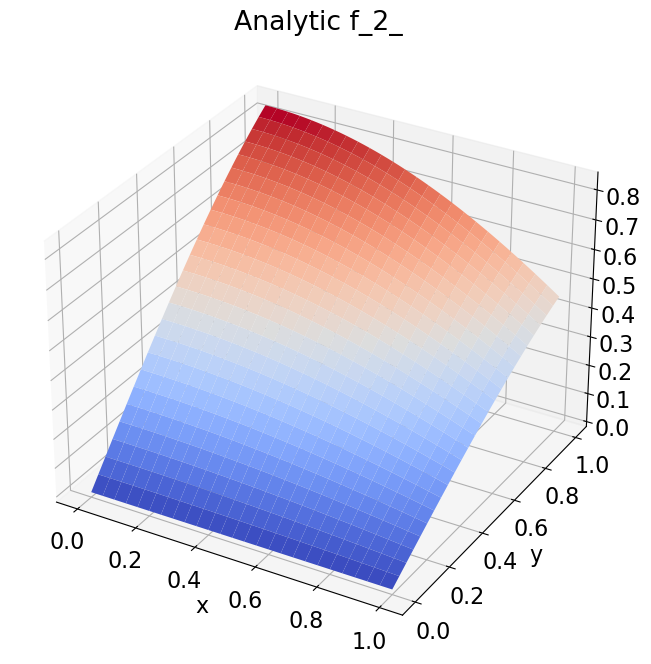

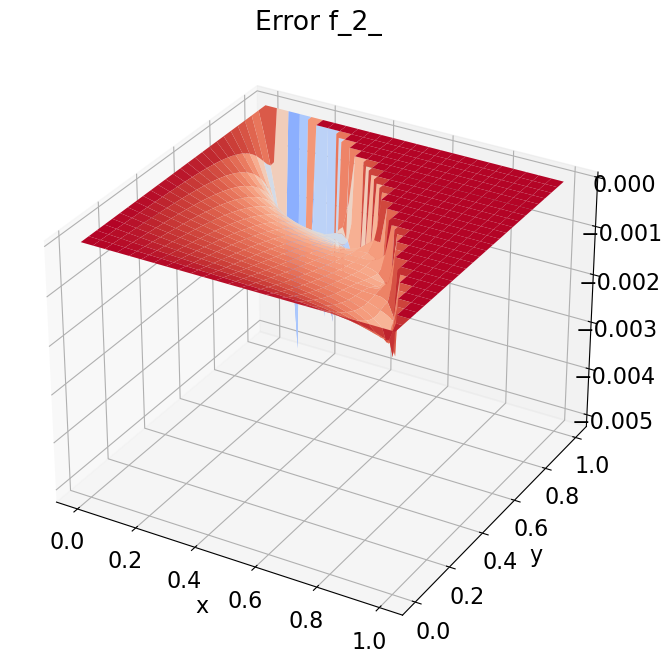

In [41]:

# FATTENING THE BOUNDARY
def scheme3(M=20, f=f_1_, g=g_1_, plot=False, error=False):

    numfix = 0.000001
    h = 1/M
    Num_points_row = np.floor(np.sqrt(-np.arange(1,M)*h+1)/h - numfix*h).astype(int) #number of grid points in each row
    #**************************** BE AWARE OF DIRTY FIX ABOVE *****************, commented on in 3.3 Observations where numfix is zeta
    Num_points_row_cum = np.cumsum(Num_points_row).astype(int) #count of point not index

    A = np.zeros((Num_points_row_cum[-1],Num_points_row_cum[-1]))
    F = np.zeros(Num_points_row_cum[-1])
    G = np.zeros(Num_points_row_cum[-1])

    index = 0
    for i in range(len(Num_points_row)):
        for j in range(Num_points_row[i]):
            F[index] = h*h*f((j+1)*h,(i+1)*h) #Define F
            A[index][index] += 4

            if(j==0 and j == Num_points_row[i]-1):
                G[index] += g(0,(i+1)*h) + g((j+1)*h,(i+1)*h,findNearest=True)
            elif j==0:
                G[index] += g(0,(i+1)*h) #Set West/Left Border
                A[index][index+1] += -1   
            elif j == Num_points_row[i]-1:
                G[index] += g((j+2)*h,(i+1)*h,findNearest=True)
                A[index][index-1] += -1  
            else:
                A[index][index-1] += -1
                A[index][index+1] += -1
            
        
            if (i==0 and (i+1)*h <= 1-((j+1)*h)**2 <= (i+2)*h):
                G[index] +=  g((j+1)*h,0) + g((j+1)*h,(i+2)*h,findNearest=True)
            elif i==0:
                G[index] += g((j+1)*h,0) #Set South/Down Border
                A[index][index+Num_points_row[i]] += -1
            elif (i+1)*h <= 1-((j+1)*h)**2 <= (i+2+numfix)*h:
                G[index] += g((j+1)*h,(i+2)*h,findNearest=True)
                A[index][index-Num_points_row[i-1]] += -1
            else:
                A[index][index-Num_points_row[i-1]] += -1
                A[index][index+Num_points_row[i]] += -1
            
            index +=1

    
    np.set_printoptions(precision=2,suppress=True)
    
    U = np.linalg.solve(A,F+G)

    X, Y = np.meshgrid(np.linspace(0,1,M+1),np.linspace(0,1,M+1))
    #from vector til matrix
    U_matrix = g(X,Y) #np.zeros((M+1, M+1))  #
    index = 0
    for i in range(len(Num_points_row)):
        for j in range(Num_points_row[i]):
            U_matrix[i+1][j+1] = U[index]
            index +=1

    if plot:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(X, Y, U_matrix, cmap=cm.coolwarm)
        ax.view_init(azim=300)              # Rotate the figure
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(r"Numerical " + f.__name__)
        
        plt.show()
    
    if error and plot:
        X, Y = np.meshgrid(np.linspace(0,1,M+1),np.linspace(0,1,M+1))
        U_matrix_anal = g(X,Y)
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(X, Y, U_matrix_anal, cmap=cm.coolwarm)
        ax.view_init(azim=300)              # Rotate the figure
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(r"Analytic " + f.__name__)
        plt.show()

        
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(X, Y, U_matrix-U_matrix_anal, cmap=cm.coolwarm)
        ax.view_init(azim=300)              # Rotate the figure
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(r"Error " + f.__name__)
        plt.show()
    
    return U_matrix
U_test3 = scheme3(M=50, f=f_1_, g=g_1_, plot=True, error=True)

U_test4 = scheme3(M=50, f=f_2_, g=g_2_, plot=True, error=True)

# U_test4 = scheme3(M=50, f=f_3, g=g_3, plot=True, error=True)


The code gives us a order of 0.9967597308654405.


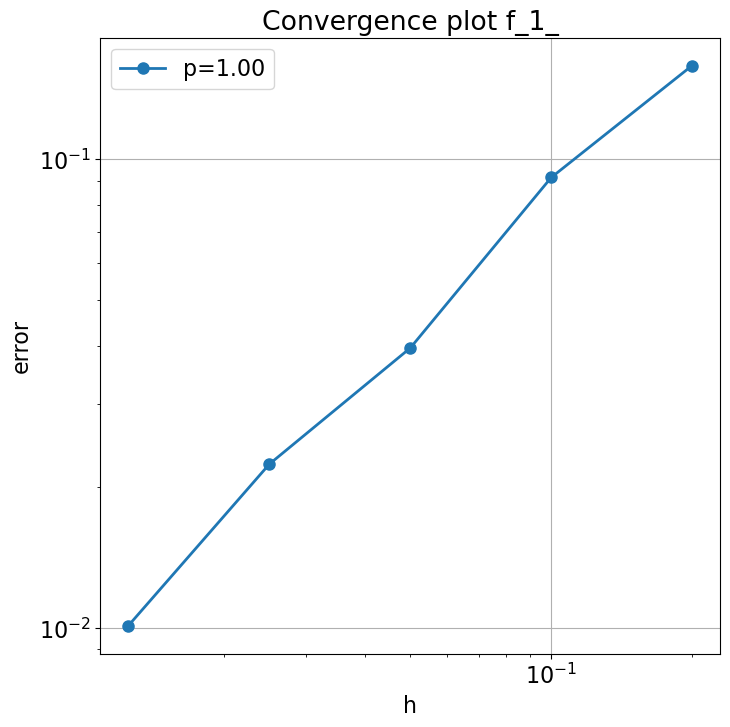

CPU times: total: 3.8 s
Wall time: 4.54 s


In [42]:
%%time
H3, E3, p3 = convergence2(f=f_1_, g=g_1_, P=5, M=5, conv_plot=True, scheme=scheme3)


The code gives us a order of 0.8569457689588738.


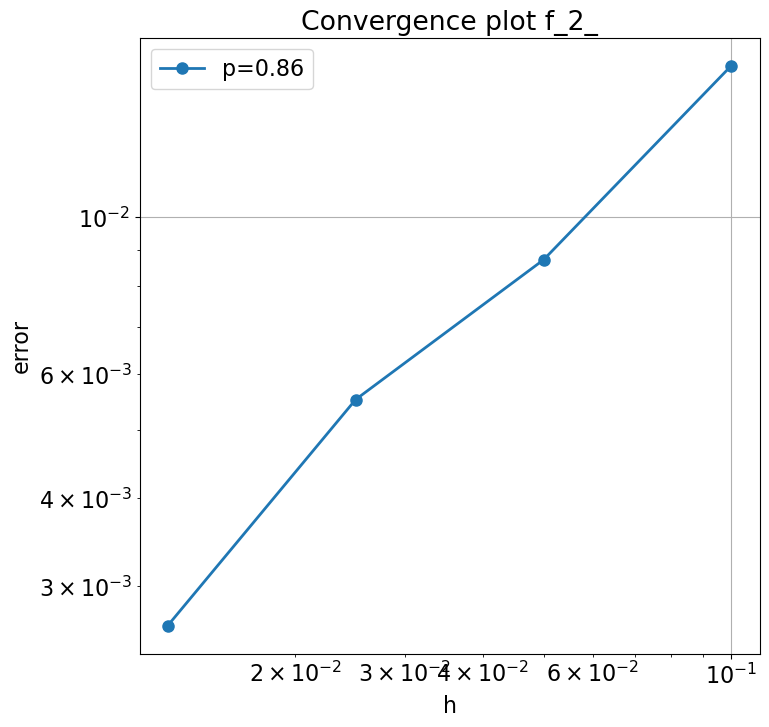

CPU times: total: 3.2 s
Wall time: 4.68 s


In [43]:
%%time
H4, E4, p4 = convergence2(f=f_2_, g=g_2_, P=4, M=10, conv_plot=True, scheme=scheme3)